In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/fruit-classification
/kaggle/input/fruit-classification/new_fruit
/kaggle/input/fruit-classification/new_fruit/apple
/kaggle/input/fruit-classification/new_fruit/papaya
/kaggle/input/fruit-classification/new_fruit/strawberry
/kaggle/input/fruit-classification/new_fruit/banana
/kaggle/input/fruit-classification/new_fruit/mango


In [2]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

{'apple': 1203, 'banana': 1162, 'mango': 1025, 'papaya': 1027, 'strawberry': 1002}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


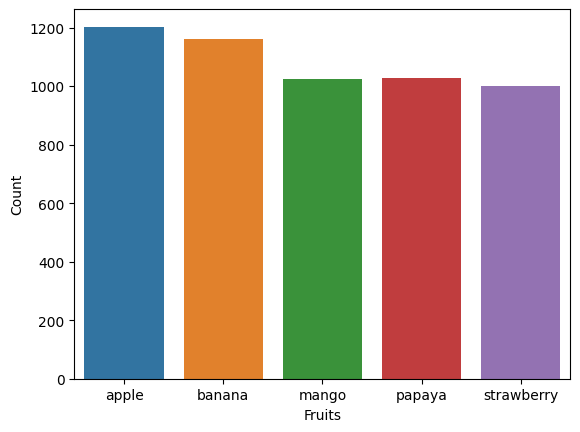

In [3]:
root_directory = '/kaggle/input/fruit-classification/new_fruit'
cls_name=['apple','banana','mango','papaya','strawberry' ]
data = {n: len(os.listdir(os.path.join(root_directory, n))) for n in cls_name}
print(data)

sns.barplot(x=list(data.keys()), y=list(data.values()))
plt.xlabel('Fruits')
plt.ylabel('Count')
plt.show()

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((114, 114)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root_directory, transform=transform)

# Specify the split ratios
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Calculate the number of samples for each split
num_samples = len(dataset)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Use random_split to split the dataset
train_data, test_val_data = random_split(dataset, [num_train, num_test + num_val])
test_data, val_data = random_split(test_val_data, [num_test, num_val])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16,shuffle=False)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

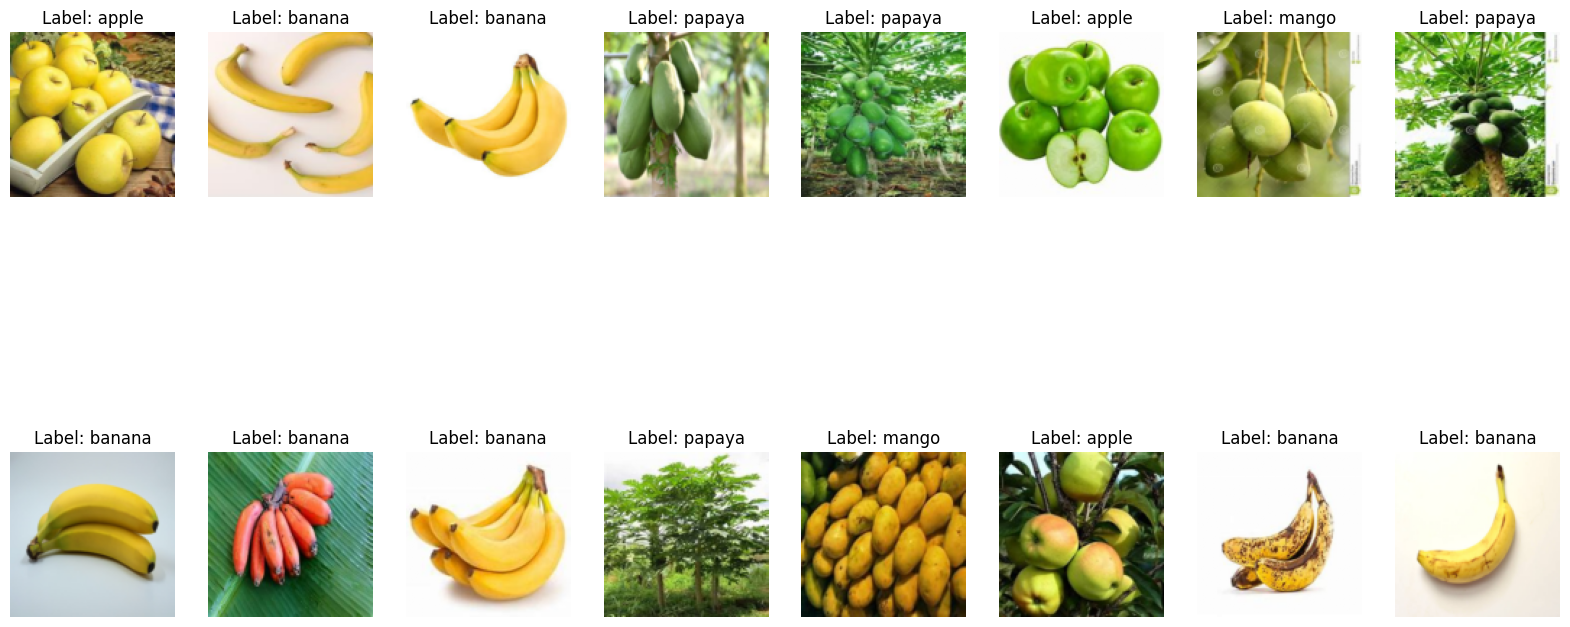

In [5]:
def show_images(images, labels):
    plt.figure(figsize=(20, 10))
    num_images = len(images)
    

    for i in range(num_images):
        plt.subplot(int(num_images/8),8, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f"Label: {cls_name[labels[i]]}")
        plt.axis('off')
    
    plt.show()

for batch, (X_train, y_train) in enumerate(train_loader):
    break

show_images(X_train, y_train)

In [6]:
X_train.shape, y_train.shape

(torch.Size([16, 3, 114, 114]), torch.Size([16]))

In [7]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(25088,128)  # Adjust the input size based on the output size of the last convolution
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128,64)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu6 = nn.ReLU()
        self.fc4 = nn.Linear(32, 16)
        self.relu7 = nn.ReLU()
        self.fc5 = nn.Linear(16, 8)
        self.relu8 = nn.ReLU()
        
        self.output_layer = nn.Linear(8, 5)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        x = self.relu7(x)
        x = self.fc5(x)
        x = self.relu8(x)
        
        x = self.output_layer(x)

        return x

In [8]:
# Move the model to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total = 0

    # Initialize running loss as a tensor with zero value
    running_loss = torch.zeros(1, device=device, requires_grad=True)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted_train = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Update the running loss using the tensor addition with detached tensor
        running_loss = running_loss + loss
        loss.backward()
        optimizer.step()

    avg_loss = running_loss.item() / len(train_loader)
    train_losses.append(avg_loss)

    train_accuracy = correct_train / total
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    # Initialize validation running loss as a tensor with zero value
    val_running_loss = torch.zeros(1, device=device, requires_grad=False)

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = model(inputs_val)
            val_loss = criterion(outputs_val, labels_val)
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

            # Update the validation running loss using the tensor addition with detached tensor
            val_running_loss = val_running_loss.detach() + val_loss

        val_avg_loss = val_running_loss.item() / len(val_loader)
        val_losses.append(val_avg_loss)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_avg_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch [1/20], Train Loss: 1.6122, Validation Loss: 1.6069, Train Accuracy: 19.95%, Validation Accuracy: 23.20%
Epoch [2/20], Train Loss: 1.6090, Validation Loss: 1.6082, Train Accuracy: 21.48%, Validation Accuracy: 23.20%
Epoch [3/20], Train Loss: 1.6080, Validation Loss: 1.6057, Train Accuracy: 21.38%, Validation Accuracy: 23.20%
Epoch [4/20], Train Loss: 1.6083, Validation Loss: 1.6068, Train Accuracy: 21.31%, Validation Accuracy: 23.20%
Epoch [5/20], Train Loss: 1.6079, Validation Loss: 1.6093, Train Accuracy: 22.01%, Validation Accuracy: 20.26%
Epoch [6/20], Train Loss: 1.6084, Validation Loss: 1.6073, Train Accuracy: 21.89%, Validation Accuracy: 23.20%
Epoch [7/20], Train Loss: 1.6075, Validation Loss: 1.6111, Train Accuracy: 21.43%, Validation Accuracy: 20.26%
Epoch [8/20], Train Loss: 1.6078, Validation Loss: 1.6101, Train Accuracy: 21.48%, Validation Accuracy: 23.20%
Epoch [9/20], Train Loss: 1.6078, Validation Loss: 1.6075, Train Accuracy: 21.64%, Validation Accuracy: 23.20%
E

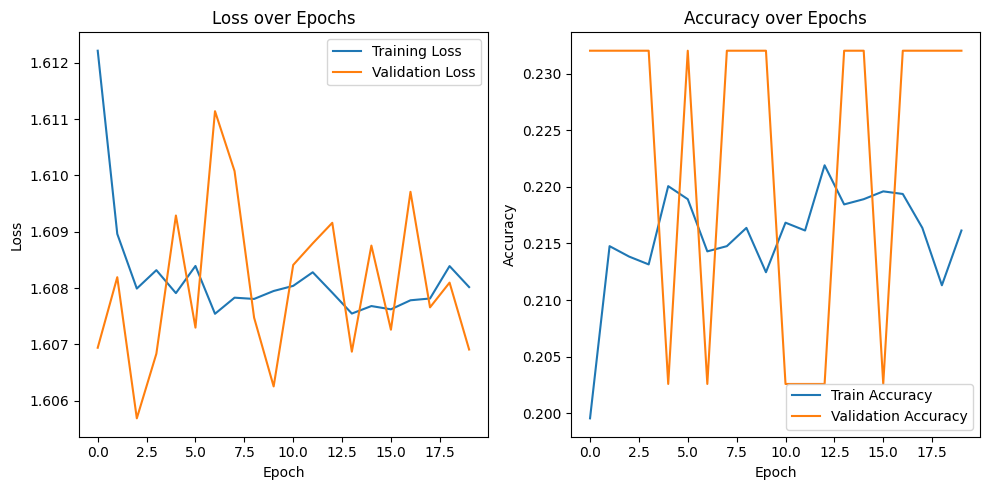

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
model.eval()
correct_test = 0
total_test = 0
true_labels=[]
predict_label=[]
predicted_probas=[]
with torch.inference_mode():
    for inputs_test, labels_test in test_loader:
        true_labels.append(labels_test)
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = model(inputs_test)
        probas = nn.functional.softmax(outputs_test, dim=1)
        predicted_probas.append(probas)
        _, predicted_test = torch.max(outputs_test.data, 1)
        predict_label.append(predicted_test)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()
test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 21.63%


In [12]:
true_labels = torch.cat(true_labels, dim=0)
predict_label= torch.cat(predict_label, dim=0)
predicted_probas= torch.cat(predicted_probas, dim=0)
predict_label=predict_label.to('cpu')
predicted_probas=predicted_probas.to('cpu')

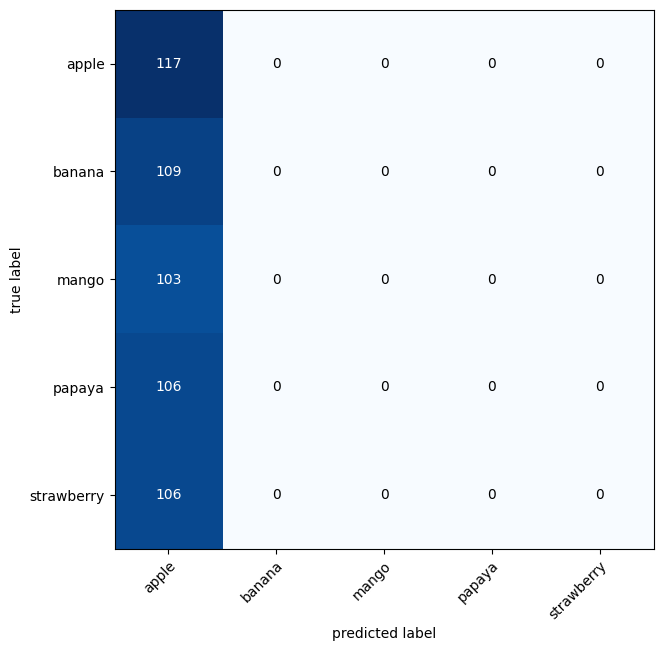

In [13]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(num_classes=len(cls_name), task='multiclass')
confmat_tensor = confmat(preds=predict_label,
                         target=true_labels)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=cls_name,
    figsize=(10, 7)
);

In [14]:
from sklearn.metrics import classification_report,roc_curve,auc

# Generate the classification report
print(classification_report(true_labels, predict_label))

              precision    recall  f1-score   support

           0       0.22      1.00      0.36       117
           1       0.00      0.00      0.00       109
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00       106

    accuracy                           0.22       541
   macro avg       0.04      0.20      0.07       541
weighted avg       0.05      0.22      0.08       541



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
top1_predictions = torch.topk(torch.tensor(predicted_probas).clone().detach(), k=1, dim=1)[1]

top1_correct = [true_label.item() in top1_pred.numpy() for top1_pred, true_label in zip(top1_predictions, true_labels)]
top1_accuracy = sum(top1_correct) / len(true_labels)

top2_predictions = torch.topk(torch.tensor(predicted_probas).clone().detach(), k=2, dim=1)[1]

top2_correct = [true_label.item() in top2_pred.numpy() for top2_pred, true_label in zip(top2_predictions, true_labels)]
top2_accuracy = sum(top2_correct) / len(true_labels)

top3_predictions = torch.topk(torch.tensor(predicted_probas).clone().detach(), k=3, dim=1)[1]

top3_correct = [true_label.item() in top3_pred.numpy() for top3_pred, true_label in zip(top3_predictions, true_labels)]
top3_accuracy = sum(top3_correct) / len(true_labels)

print(f'Top-1 Accuracy: {top1_accuracy * 100:.2f}%')
print(f'Top-2 Accuracy: {top2_accuracy * 100:.2f}%')
print(f'Top-3 Accuracy: {top3_accuracy * 100:.2f}%')

Top-1 Accuracy: 21.63%
Top-2 Accuracy: 41.77%
Top-3 Accuracy: 61.37%


/tmp/ipykernel_26/2479647448.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top1_predictions = torch.topk(torch.tensor(predicted_probas).clone().detach(), k=1, dim=1)[1]
/tmp/ipykernel_26/2479647448.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2_predictions = torch.topk(torch.tensor(predicted_probas).clone().detach(), k=2, dim=1)[1]
/tmp/ipykernel_26/2479647448.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top3_predictions = torch.topk(torch.tensor(predicted_probas).clone().detach(), k=3, dim=1)[1]


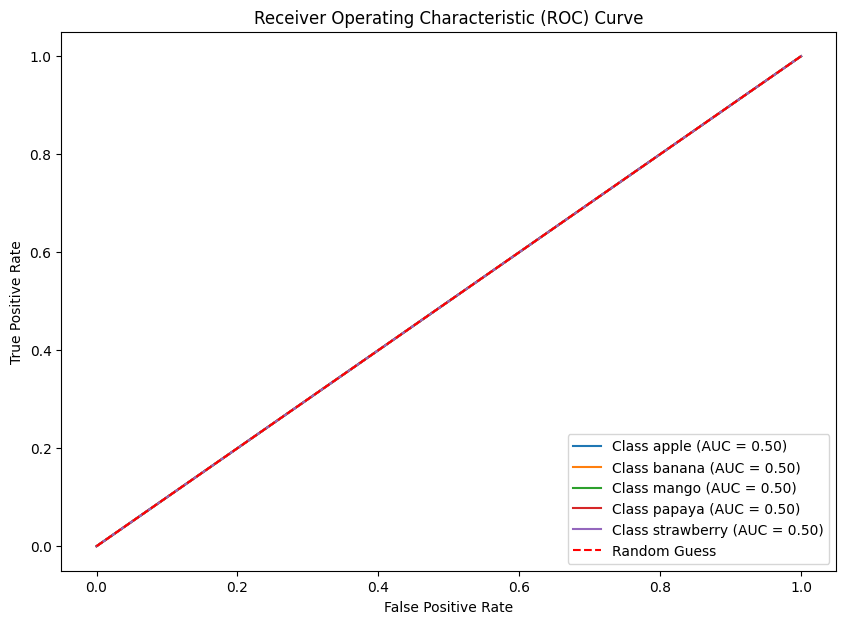

In [16]:
all_fpr = []
all_tpr = []
all_auc = []

num_classes = len(cls_name)


plt.figure(figsize=(10, 7))
true_labels_one_hot = torch.nn.functional.one_hot(true_labels)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot [:, i], predicted_probas[:, i])
    roc_auc = auc(fpr, tpr)

    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    plt.plot(fpr, tpr, label=f'Class {cls_name[i]} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()